# Semiconductor Clustering
### Overview
### Steps
1. Read data and preprocess.
2. Generate features through pretrained neural networks.
3. Dimension reduction,  visualization
4. Find centers of each class. TODO
5. Test. TODO

In [1]:
import os
import torch
from torch import pca_lowrank
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms, utils
import torchvision.models as models
from torchvision.transforms import ToTensor, Resize
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition

### Parameters

In [2]:
model_name = 'resnet18' # resnet18, resnet34, resnet50, resnet101, densenet121, densenet161, vgg16, resnet50
file_path = 'classify8.22_init'
resize = 224 # for resnet 18/34/50
classes = [5, 10, 15, 20, 25] # 
# classes = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]

### 1. Read data and preprocess

In [3]:
class SemiconDataset(Dataset):
    '''
    File path structure: root/cls_idx/img_idx.jpg
    '''
    
    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.folders = []
        self.folder_images = {}
        self.folder_image_list = []
        self.length = 0
        self.transform = transform
        
        for root, subdirs, files in os.walk(file_path):
            if root == file_path:
                ### 1st level, folders
                for subdir in subdirs:
                    self.folders.append(subdir)
            else:
                # 2nd level, images
                folder = root.split('/')[1]
                self.folder_images[folder] = files
                self.length += len(files)
        for folder, images in self.folder_images.items():
            for image in images:
                self.folder_image_list.append((folder, image))
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.file_path, *self.folder_image_list[idx])
#         image = read_image(image_path, ImageReadMode.GRAY)
        image = read_image(image_path)
        image = image/255
        if self.transform:
            image = self.transform(image)
        label = self.folder_image_list[idx][0]
        return image, label, image_path


_transforms = transforms.Compose([Resize((resize, resize)),
                                  #ToTensor()
                                 ])
dataset = SemiconDataset(file_path, _transforms)
dataloader = DataLoader(dataset, batch_size=1,shuffle=False, num_workers=0)

### 2. Generate features through pretrained neural networks.
1. Models finetuned on semicon data should have better results.
2. Current features may not make sense.

In [4]:
model_dict = {'resnet18':models.resnet18(pretrained=True),
              'resnet34':models.resnet34(pretrained=True),
              'resnet50':models.resnet50(pretrained=True),
              'resnet121':models.resnet101(pretrained=True),
              'vgg16':models.vgg16(pretrained=True),
              'densenet121':models.densenet121(pretrained=True),
              'densenet161':models.densenet161(pretrained=True)
}
model = model_dict[model_name] # resnet18 output size: 512
    
### strip the last layer
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
cls_img_ft = {}
sequential_outputs = []
for data, label, image_path in dataloader:
    out = feature_extractor(data)
    out = torch.flatten(out)
    out = torch.unsqueeze(out, dim=0)
    label = int(label[0])
    if label not in cls_img_ft:
        cls_img_ft[label] = [{'image_path': image_path[0], 'features': out}]
    else:
        cls_img_ft[label].append({'image_path': image_path[0], 'features': out})
    sequential_outputs.append([label, image_path[0], out])

# cls_img_ft[16][2]['features']

/home/peisheng/semicon/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 3. Dimension reduction.

In [5]:
# PCA
x = torch.vstack([output[2] for output in sequential_outputs])
np_x = x.detach().numpy()

pca = decomposition.PCA(n_components=2)
pca.fit(np_x)
np_x = pca.transform(np_x)

### Visualization

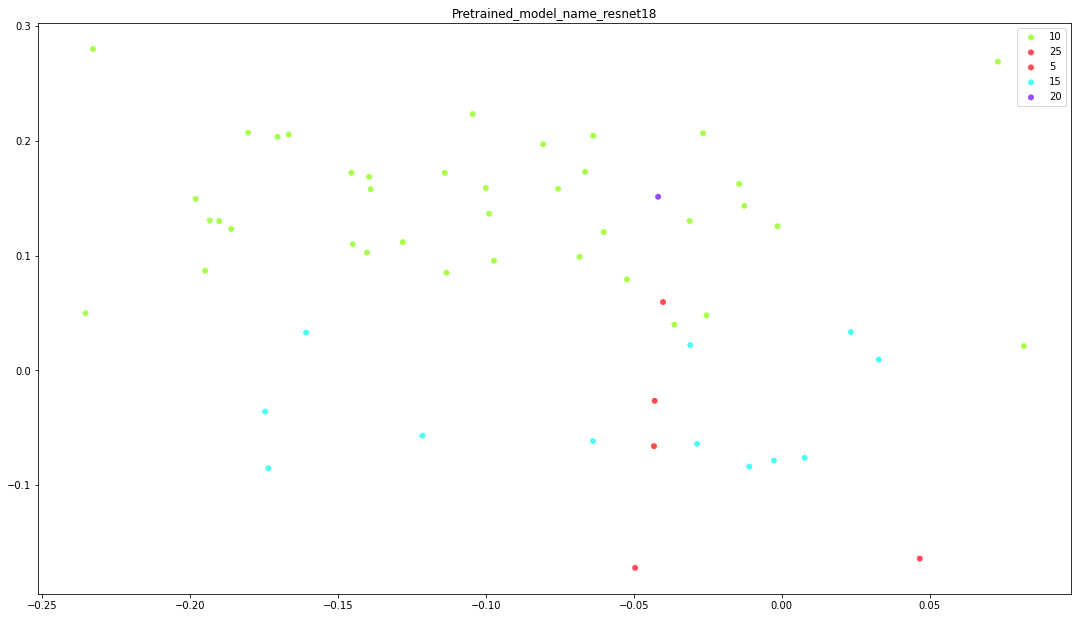

In [6]:
# plt.scatter(np_x[:,0], np_x[:,1])

# class_colours = ['r','b','g', 'c', 'm', 'y', 'k', 'w']
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

fig, ax = plt.subplots()
class_colours = get_cmap(len(classes))
current_label = None
for sequential_output, coord in zip(sequential_outputs, np_x):
    label = sequential_output[0]
    if label in classes:
        color = classes.index(label)
        ax.scatter(coord[0], coord[1], color=class_colours(color), label=label if current_label != label else '', alpha=0.7, edgecolors='none')
        current_label = label

ax.legend()
title = 'Pretrained_model_name_'+ model_name
ax.title.set_text(title)
fig.set_size_inches(18.5, 10.5)

### 4. Find centers of each class. TODO

### 5. Test. TODO